### Set MINI = TRUE to run with mini sample

In [1]:
"""
For TAs: Set TRUE to run with mini sample 
"""
MINI = True

In [2]:
if MINI:
    train_days = [1]
    test_days = [10]
    EPOCHS = 5
else:
    train_days = [7]
    test_days = [8,9,10] 
    EPOCHS = 50

(MINI, EPOCHS, train_days, test_days)

(True, 5, [1], [8])

Dataset Can be directly downloaded from:
https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649

In [3]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.deep_lob import DeepLOB
from models.trans_lob import TransLOB
from models.deep_trans_lob import DeepTransLOB
from utils.fi2010_loader import load_fi2010
from utils.training import train_validate, train, validate, evaluate_and_plot
from utils.plots import plot_training_history, plot_label_distributions
from utils.preprocessing import generate_labels, normalize_features

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
DATASET_TYPE = "fi2010"
NORMALIZATION = "DecPre"

LEVELS = 10
BATCH_SIZE = 128
TEST_RATIO = 0.3
WINDOW_SIZE = 100

LEARNING_RATE = 1e-4 
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

T = 100
stock = [0,1,2,3,4]
k = 4

# DeepLOB

Training Data Size : 39017
Validation Data Size : 54983


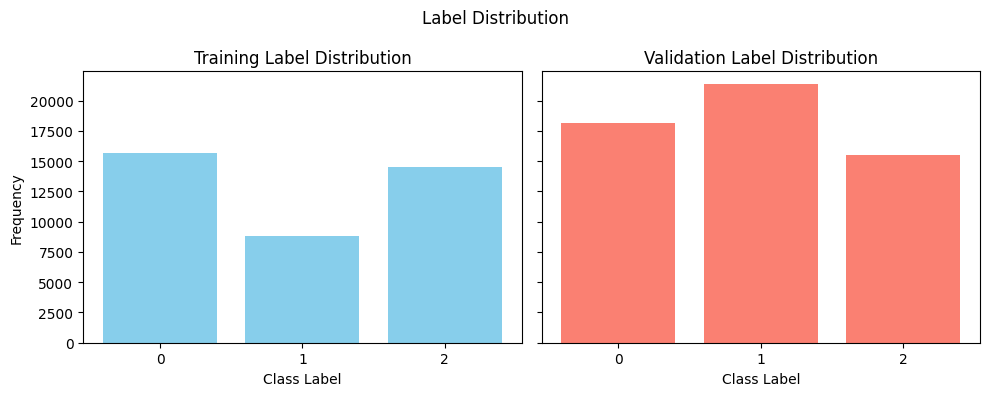

In [6]:
train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, 
                                                       train_days, test_days, T, k, True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [7]:
model_deepLOB = DeepLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
DeepLOB                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [8]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepLOB, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/5: Train Loss 1.0326 | Train Acc 0.4931 | Val Loss 1.0904 | Val Acc 0.3765
Epoch 2/5: Train Loss 0.9541 | Train Acc 0.5855 | Val Loss 1.0767 | Val Acc 0.4097
Epoch 3/5: Train Loss 0.8960 | Train Acc 0.6497 | Val Loss 1.1127 | Val Acc 0.4055
Epoch 4/5: Train Loss 0.8577 | Train Acc 0.6898 | Val Loss 1.1307 | Val Acc 0.3986
Epoch 5/5: Train Loss 0.8270 | Train Acc 0.7205 | Val Loss 1.0897 | Val Acc 0.4436


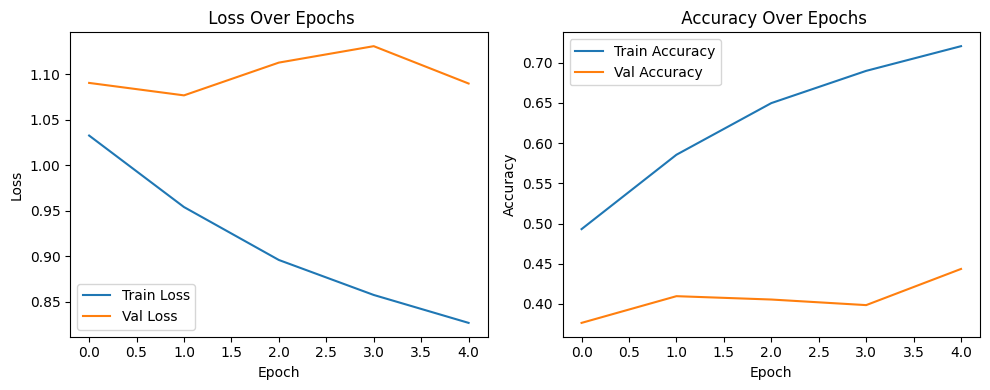

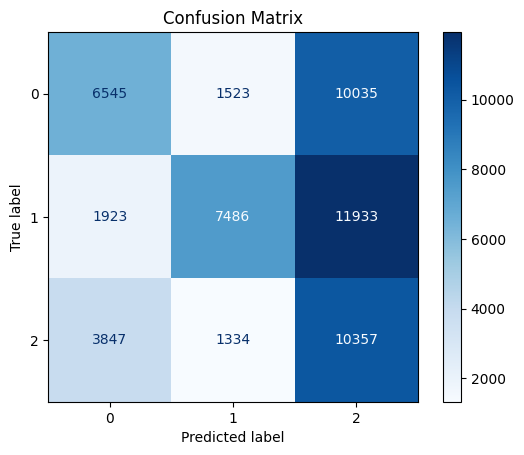

              precision    recall  f1-score   support

           0     0.5315    0.3615    0.4303     18103
           1     0.7238    0.3508    0.4725     21342
           2     0.3204    0.6666    0.4328     15538

    accuracy                         0.4436     54983
   macro avg     0.5252    0.4596    0.4452     54983
weighted avg     0.5465    0.4436    0.4474     54983



In [9]:
plot_training_history(history)
evaluate_and_plot(model_deepLOB, val_loader, device)

# TransLOB

Training Data Size : 39017
Validation Data Size : 54983


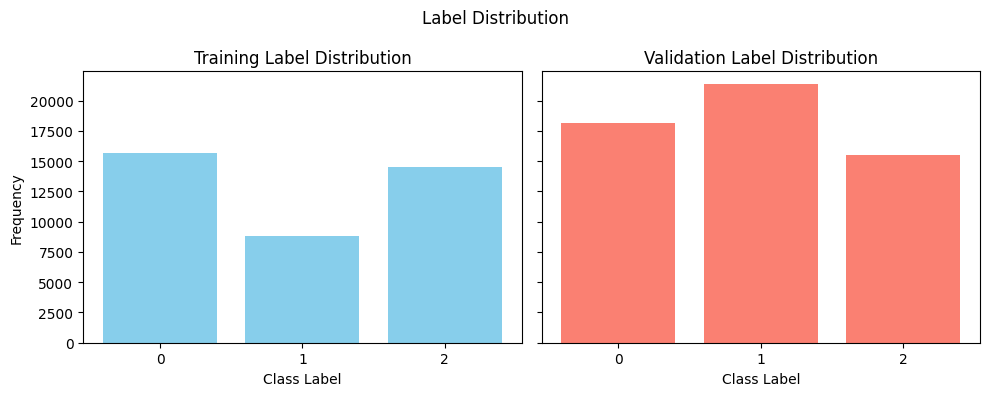

In [10]:
BATCH_SIZE = 32 # TransLOB Paper parameter

train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, train_days, test_days, T, k, False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [11]:
model_transLOB = TransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=LEARNING_RATE, betas =(ADAM_B1,ADAM_B2),weight_decay=WEIGHT_DECAY)

summary(model_transLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─LOBTransformerBlock: 1-4               [1, 100, 15]              --
│    └─MultiheadAttention: 2-6           [1, 100, 15]              960
│    └─LayerNorm: 2-7                    [1, 100, 15]              30
│    └─Sequential: 2-8                   [1, 100, 15]              --
│    │ 

In [12]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/5: Train Loss 1.0721 | Train Acc 0.3935 | Val Loss 1.1618 | Val Acc 0.3292
Epoch 2/5: Train Loss 1.0700 | Train Acc 0.3992 | Val Loss 1.1586 | Val Acc 0.3292
Epoch 3/5: Train Loss 1.0433 | Train Acc 0.4253 | Val Loss 1.2067 | Val Acc 0.3353
Epoch 4/5: Train Loss 1.0299 | Train Acc 0.4308 | Val Loss 1.1678 | Val Acc 0.3338
Epoch 5/5: Train Loss 1.0234 | Train Acc 0.4343 | Val Loss 1.1840 | Val Acc 0.3105


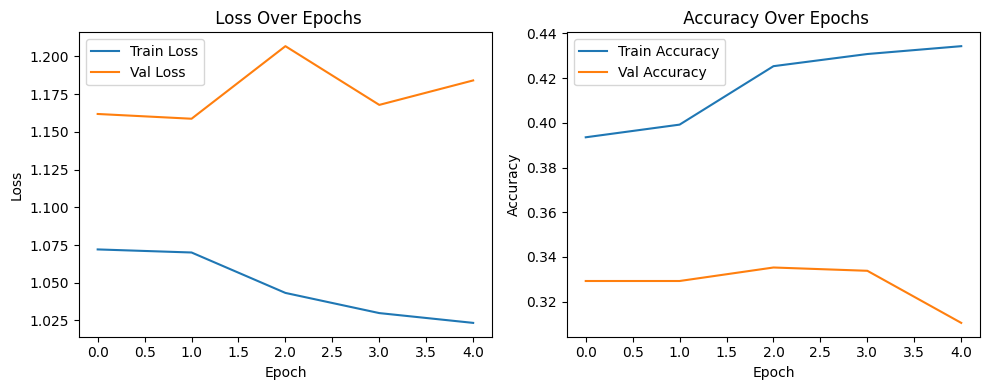

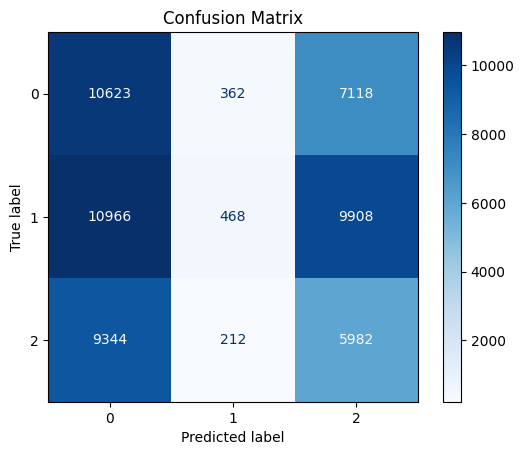

              precision    recall  f1-score   support

           0     0.3434    0.5868    0.4333     18103
           1     0.4491    0.0219    0.0418     21342
           2     0.2600    0.3850    0.3104     15538

    accuracy                         0.3105     54983
   macro avg     0.3509    0.3312    0.2618     54983
weighted avg     0.3609    0.3105    0.2466     54983



In [13]:
plot_training_history(history)
evaluate_and_plot(model_transLOB, val_loader, device)

# DeepTransLOB

Training Data Size : 39017
Validation Data Size : 54983


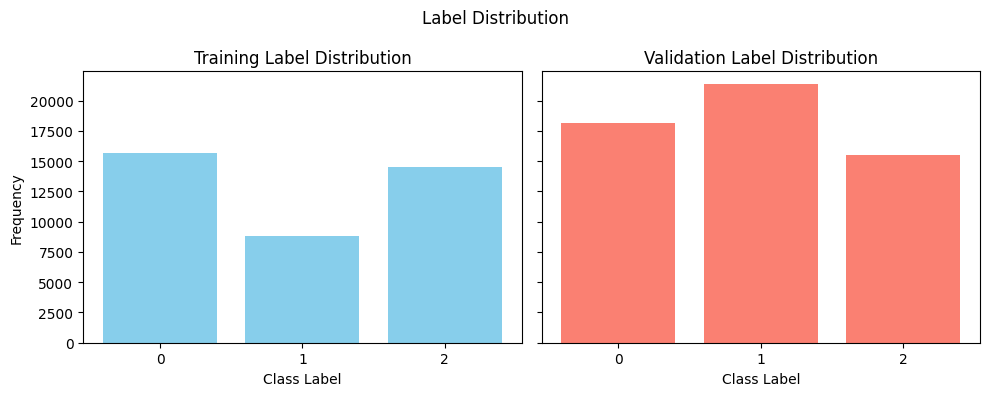

In [14]:
BATCH_SIZE = 128

train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, 
                                                       train_days, test_days, T, k, False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [15]:
model_deepTransLOB = DeepTransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepTransLOB.parameters(), lr=LEARNING_RATE, betas =(ADAM_B1,ADAM_B2),weight_decay=WEIGHT_DECAY)

summary(model_deepTransLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
DeepTransLOB                             [1, 3]                    --
├─LOBFeatureExtractor2D: 1-1             [1, 100, 64]              --
│    └─Sequential: 2-1                   [1, 64, 100, 20]          --
│    │    └─CausalConv2d: 3-1            [1, 64, 100, 20]          192
│    │    └─LeakyReLU: 3-2               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-3             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-4            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-5               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-6             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-7            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-8               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-9             [1, 64, 100, 20]          128
│    └─Sequential: 2-2                   [1, 64, 100, 10]          --
│  

In [16]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepTransLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepTransLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepTransLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/5: Train Loss 0.9710 | Train Acc 0.4884 | Val Loss 1.1464 | Val Acc 0.3979
Epoch 2/5: Train Loss 0.8297 | Train Acc 0.6103 | Val Loss 1.1734 | Val Acc 0.4460
Epoch 3/5: Train Loss 0.7168 | Train Acc 0.6900 | Val Loss 1.2132 | Val Acc 0.4317
Epoch 4/5: Train Loss 0.6286 | Train Acc 0.7409 | Val Loss 1.3332 | Val Acc 0.4177
Epoch 5/5: Train Loss 0.5532 | Train Acc 0.7816 | Val Loss 1.2636 | Val Acc 0.4438


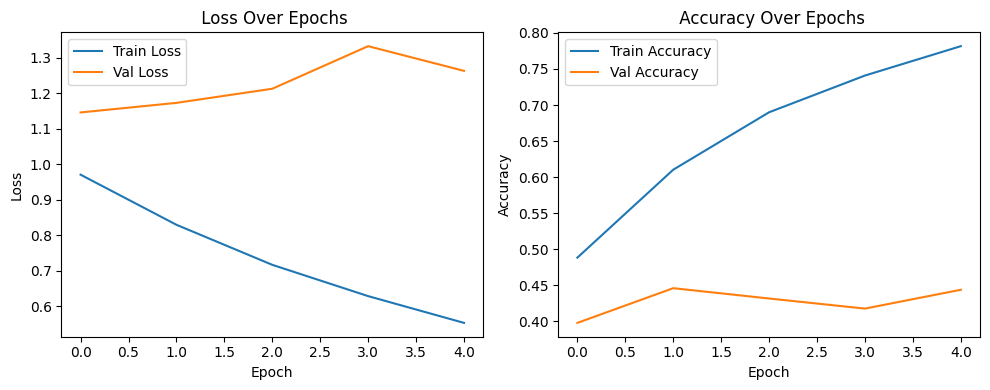

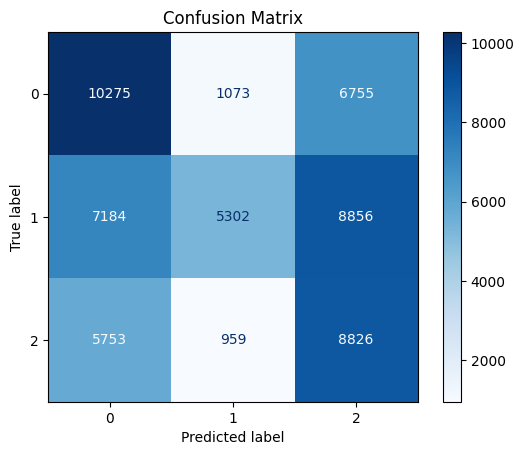

              precision    recall  f1-score   support

           0     0.4427    0.5676    0.4974     18103
           1     0.7229    0.2484    0.3698     21342
           2     0.3612    0.5680    0.4416     15538

    accuracy                         0.4438     54983
   macro avg     0.5089    0.4613    0.4363     54983
weighted avg     0.5284    0.4438    0.4321     54983



In [17]:
plot_training_history(history)
evaluate_and_plot(model_deepTransLOB, val_loader, device)